<a href="https://colab.research.google.com/github/Gibsdevops/machine-learning-with-deep-learning-/blob/main/forecasting_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

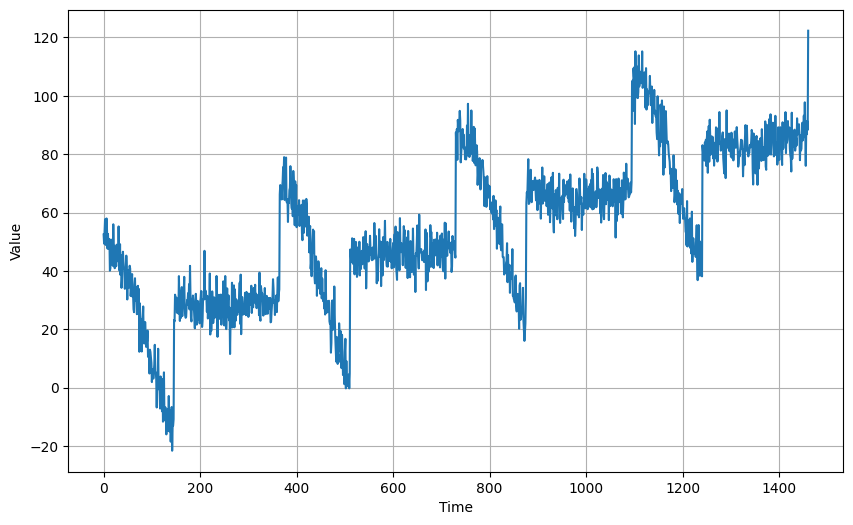

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

preprocessing with 1D cnn

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)


#define the model

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)

])

#control the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

#optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

#build the model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 66.4645 - mae: 66.9639 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 61.4654 - mae: 61.9649 - learning_rate: 1.1220e-08
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 58.4511 - mae: 58.9505 - learning_rate: 1.2589e-08
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 56.0856 - mae: 56.5849 - learning_rate: 1.4125e-08
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 55.2365 - mae: 55.7358 - learning_rate: 1.5849e-08
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 53.7740 - mae: 54.2733 - learning_rate: 1.7783e-08
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 53.1304 - mae: 53.6298 - learning_rate: 1.9953e-08
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 52.0934 - mae: 52.5925 - learning_rate: 2.2387e-08
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 51.0330 - mae: 51.5319 - learning_rate: 2.5119e-08
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 50.6425 - mae: 51.1416 - learning_rate: 2.8184e-08
Epoch 11/100
8/8 ━━━━━━━━━━━━━

(np.float64(1e-08), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

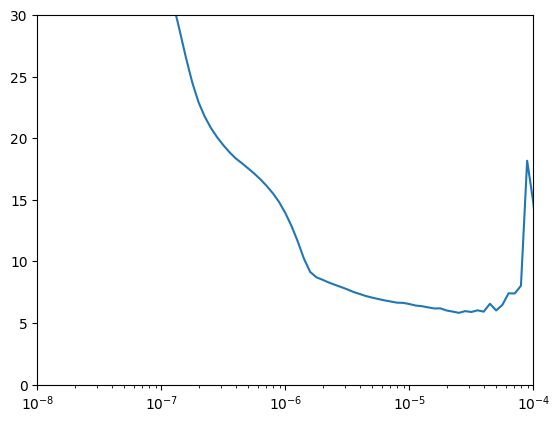

In [9]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
#after choosing the right learning rate

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


      8/Unknown 4s 42ms/step - loss: 60.5229 - mae: 61.0208

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 58.4972 - mae: 58.9950 - val_loss: 28.7262 - val_mae: 29.2249
Epoch 2/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 18.6838 - mae: 19.1778

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 18.6406 - mae: 19.1345 - val_loss: 23.4723 - val_mae: 23.9693
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 15.6078 - mae: 16.1024 - val_loss: 36.9289 - val_mae: 37.4286
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 12.4248 - mae: 12.9153 - val_loss: 25.0360 - val_mae: 25.5342
Epoch 5/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 10.0964 - mae: 10.5847

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 10.0377 - mae: 10.5261 - val_loss: 17.7409 - val_mae: 18.2343
Epoch 6/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8.8349 - mae: 9.3209

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 8.8134 - mae: 9.2995 - val_loss: 15.9318 - val_mae: 16.4251
Epoch 7/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.1787 - mae: 8.6638

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 8.1710 - mae: 8.6562 - val_loss: 15.7248 - val_mae: 16.2174
Epoch 8/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.9105 - mae: 8.3948

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 7.8576 - mae: 8.3419 - val_loss: 15.5406 - val_mae: 16.0329
Epoch 9/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.2118 - mae: 7.6936

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 7.2298 - mae: 7.7117 - val_loss: 14.9530 - val_mae: 15.4463
Epoch 10/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.9891 - mae: 7.4710

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.9861 - mae: 7.4680 - val_loss: 13.9333 - val_mae: 14.4235
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.7277 - mae: 7.2095

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.7268 - mae: 7.2086 - val_loss: 12.5756 - val_mae: 13.0644
Epoch 12/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.4746 - mae: 6.9556

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 6.4766 - mae: 6.9575 - val_loss: 12.1668 - val_mae: 12.6544
Epoch 13/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.3780 - mae: 6.8575

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 6.3606 - mae: 6.8401 - val_loss: 11.6053 - val_mae: 12.0927
Epoch 14/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.2632 - mae: 6.7424

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 6.2375 - mae: 6.7167 - val_loss: 11.0142 - val_mae: 11.5017
Epoch 15/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.0311 - mae: 6.5100

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 6.0318 - mae: 6.5108 - val_loss: 10.5911 - val_mae: 11.0784
Epoch 16/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.9127 - mae: 6.3913

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 5.9161 - mae: 6.3947 - val_loss: 10.2393 - val_mae: 10.7251
Epoch 17/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.8899 - mae: 6.3681

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 5.8805 - mae: 6.3587 - val_loss: 9.9523 - val_mae: 10.4379
Epoch 18/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.8499 - mae: 6.3295

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.8329 - mae: 6.3124 - val_loss: 9.7869 - val_mae: 10.2717
Epoch 19/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.6919 - mae: 6.1707

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.6962 - mae: 6.1750 - val_loss: 9.7574 - val_mae: 10.2440
Epoch 20/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.6203 - mae: 6.0981

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 5.6246 - mae: 6.1024 - val_loss: 9.1713 - val_mae: 9.6552
Epoch 21/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.6866 - mae: 6.1658

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.6732 - mae: 6.1522 - val_loss: 9.0577 - val_mae: 9.5413
Epoch 22/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.5727 - mae: 6.0504 - val_loss: 9.1162 - val_mae: 9.6004
Epoch 23/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.5438 - mae: 6.0219

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.5393 - mae: 6.0174 - val_loss: 8.6812 - val_mae: 9.1642
Epoch 24/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.4620 - mae: 5.9398

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.4744 - mae: 5.9522 - val_loss: 8.6194 - val_mae: 9.1028
Epoch 25/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.5358 - mae: 6.0144 - val_loss: 8.6395 - val_mae: 9.1228
Epoch 26/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.4857 - mae: 5.9649

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 5.4763 - mae: 5.9551 - val_loss: 8.5668 - val_mae: 9.0497
Epoch 27/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.4352 - mae: 5.9131

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.4262 - mae: 5.9040 - val_loss: 8.4167 - val_mae: 8.9000
Epoch 28/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 5.3694 - mae: 5.8482 - val_loss: 8.5292 - val_mae: 9.0136
Epoch 29/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.2430 - mae: 5.7210

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 5.2585 - mae: 5.7366 - val_loss: 8.3360 - val_mae: 8.8199
Epoch 30/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.3167 - mae: 5.7956

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.3206 - mae: 5.7995 - val_loss: 8.2861 - val_mae: 8.7700
Epoch 31/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.3566 - mae: 5.8348 - val_loss: 8.2978 - val_mae: 8.7815
Epoch 32/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.3306 - mae: 5.8089

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.3247 - mae: 5.8029 - val_loss: 8.1345 - val_mae: 8.6183
Epoch 33/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.3305 - mae: 5.8089

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.3281 - mae: 5.8065 - val_loss: 7.9013 - val_mae: 8.3842
Epoch 34/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.2950 - mae: 5.7728 - val_loss: 8.2411 - val_mae: 8.7244
Epoch 35/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.2453 - mae: 5.7234 - val_loss: 8.1333 - val_mae: 8.6164
Epoch 36/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.2564 - mae: 5.7331

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.2487 - mae: 5.7255 - val_loss: 7.7747 - val_mae: 8.2572
Epoch 37/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.1541 - mae: 5.6314 - val_loss: 7.8264 - val_mae: 8.3105
Epoch 38/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.1224 - mae: 5.6000

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 5.1388 - mae: 5.6164 - val_loss: 7.7374 - val_mae: 8.2205
Epoch 39/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1380 - mae: 5.6149

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 5.1465 - mae: 5.6234 - val_loss: 7.6516 - val_mae: 8.1331
Epoch 40/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - loss: 5.1926 - mae: 5.6696 - val_loss: 7.6584 - val_mae: 8.1418
Epoch 41/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.1383 - mae: 5.6164 - val_loss: 7.9679 - val_mae: 8.4498
Epoch 42/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.1674 - mae: 5.6448 - val_loss: 8.3609 - val_mae: 8.8454
Epoch 43/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 5.1752 - mae: 5.6525 - val_loss: 8.0932 - val_mae: 8.5763
Epoch 44/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.1570 - mae: 5.6343 - val_loss: 8.0443 - val_mae: 8.5283
Epoch 45/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.1791 - mae: 5.6572

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.1690 - mae: 5.6470 - val_loss: 7.4307 - val_mae: 7.9119
Epoch 46/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.1022 - mae: 5.5795 - val_loss: 7.5724 - val_mae: 8.0567
Epoch 47/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.0922 - mae: 5.5696

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.0924 - mae: 5.5697 - val_loss: 7.2973 - val_mae: 7.7787
Epoch 48/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.0687 - mae: 5.5457 - val_loss: 7.3703 - val_mae: 7.8517
Epoch 49/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.1150 - mae: 5.5919 - val_loss: 7.6590 - val_mae: 8.1410
Epoch 50/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 5.0607 - mae: 5.5368 - val_loss: 7.8448 - val_mae: 8.3281
Epoch 51/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 5.0591 - mae: 5.5354 - val_loss: 7.7653 - val_mae: 8.2472
Epoch 52/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.0557 - mae: 5.5327 - val_loss: 7.3970 - val_mae: 7.8812
Epoch 53/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 5.1472 - mae: 5.6234

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 5.1244 - mae: 5.6007 - val_loss: 7.2040 - val_mae: 7.6878
Epoch 54/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5.0263 - mae: 5.5037

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5.0291 - mae: 5.5065 - val_loss: 7.1971 - val_mae: 7.6790
Epoch 55/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 5.0553 - mae: 5.5320 - val_loss: 7.5795 - val_mae: 8.0612
Epoch 56/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.0902 - mae: 5.5666

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 5.0770 - mae: 5.5535 - val_loss: 7.1894 - val_mae: 7.6721
Epoch 57/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.0010 - mae: 5.4775

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 5.0038 - mae: 5.4802 - val_loss: 7.0721 - val_mae: 7.5552
Epoch 58/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.0862 - mae: 5.5631 - val_loss: 7.3058 - val_mae: 7.7892
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4.9768 - mae: 5.4535 - val_loss: 7.2732 - val_mae: 7.7577
Epoch 60/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.9964 - mae: 5.4738

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.9939 - mae: 5.4712 - val_loss: 7.0293 - val_mae: 7.5107
Epoch 61/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.9877 - mae: 5.4662 - val_loss: 7.4496 - val_mae: 7.9302
Epoch 62/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.0072 - mae: 5.4844 - val_loss: 7.0446 - val_mae: 7.5274
Epoch 63/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.9580 - mae: 5.4351

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.9647 - mae: 5.4419 - val_loss: 6.9750 - val_mae: 7.4576
Epoch 64/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.0203 - mae: 5.4972 - val_loss: 7.2792 - val_mae: 7.7609
Epoch 65/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 4.9197 - mae: 5.3973 - val_loss: 7.6205 - val_mae: 8.1039
Epoch 66/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.9566 - mae: 5.4335 - val_loss: 7.2781 - val_mae: 7.7594
Epoch 67/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.9541 - mae: 5.4309 - val_loss: 7.4676 - val_mae: 7.9501
Epoch 68/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.0230 - mae: 5.4998

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.0150 - mae: 5.4919 - val_loss: 6.9070 - val_mae: 7.3892
Epoch 69/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.0233 - mae: 5.4995 - val_loss: 7.5291 - val_mae: 8.0124
Epoch 70/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.0076 - mae: 5.4846 - val_loss: 6.9211 - val_mae: 7.4029
Epoch 71/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.9439 - mae: 5.4210

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.9392 - mae: 5.4162 - val_loss: 6.8081 - val_mae: 7.2909
Epoch 72/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.9103 - mae: 5.3871 - val_loss: 6.9607 - val_mae: 7.4439
Epoch 73/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.9517 - mae: 5.4281 - val_loss: 7.2381 - val_mae: 7.7178
Epoch 74/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.9851 - mae: 5.4620 - val_loss: 6.8716 - val_mae: 7.3544
Epoch 75/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.8815 - mae: 5.3590 - val_loss: 7.3837 - val_mae: 7.8664
Epoch 76/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.9306 - mae: 5.4076 - val_loss: 6.9391 - val_mae: 7.4224
Epoch 77/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.8918 - mae: 5.3682 - val_loss: 6.9713 - val_mae: 7.4530
Epoch 78/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.8961 - mae: 5.3725 - val_loss: 6.8872 - val_mae: 7.3702
Epoch 79/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.9263 - mae: 5.40

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 4.8631 - mae: 5.3397 - val_loss: 6.6158 - val_mae: 7.0971
Epoch 82/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.9063 - mae: 5.3822 - val_loss: 7.3874 - val_mae: 7.8701
Epoch 83/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.8942 - mae: 5.3713 - val_loss: 6.6276 - val_mae: 7.1106
Epoch 84/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.8628 - mae: 5.3393 - val_loss: 7.2574 - val_mae: 7.7396
Epoch 85/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.9264 - mae: 5.4029

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.9162 - mae: 5.3927 - val_loss: 6.5894 - val_mae: 7.0685
Epoch 86/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.9873 - mae: 5.4647 - val_loss: 7.3075 - val_mae: 7.7897
Epoch 87/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.8795 - mae: 5.3570 - val_loss: 7.2216 - val_mae: 7.7031
Epoch 88/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.8473 - mae: 5.3237 - val_loss: 6.6655 - val_mae: 7.1477
Epoch 89/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.8463 - mae: 5.3224 - val_loss: 6.8197 - val_mae: 7.3031
Epoch 90/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.8444 - mae: 5.3201 - val_loss: 6.9197 - val_mae: 7.3996
Epoch 91/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.8253 - mae: 5.3018

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8273 - mae: 5.3037 - val_loss: 6.5749 - val_mae: 7.0570
Epoch 92/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.7689 - mae: 5.2464

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.7813 - mae: 5.2587 - val_loss: 6.5267 - val_mae: 7.0087
Epoch 93/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.8263 - mae: 5.3031 - val_loss: 7.0213 - val_mae: 7.5007
Epoch 94/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.8977 - mae: 5.3744

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.8965 - mae: 5.3732 - val_loss: 6.4554 - val_mae: 6.9351
Epoch 95/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.9473 - mae: 5.4250 - val_loss: 7.2764 - val_mae: 7.7585
Epoch 96/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.8327 - mae: 5.3103 - val_loss: 6.8697 - val_mae: 7.3514
Epoch 97/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 4.7975 - mae: 5.2729 - val_loss: 6.7014 - val_mae: 7.1847
Epoch 98/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 4.8434 - mae: 5.3201 - val_loss: 7.4465 - val_mae: 7.9287
Epoch 99/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 4.8500 - mae: 5.3262 - val_loss: 6.7312 - val_mae: 7.2150
Epoch 100/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 4.8100 - mae: 5.2862 - val_loss: 6.8534 - val_mae: 7.3347
Epoch 101/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.8036 - mae: 5.2790 - val_loss: 7.0285 - val_mae: 7.5097
Epoch 102/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.7712 - mae

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 4.8129 - mae: 5.2893 - val_loss: 6.4199 - val_mae: 6.9024
Epoch 106/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 4.8320 - mae: 5.3078 - val_loss: 6.5776 - val_mae: 7.0605
Epoch 107/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 4.7616 - mae: 5.2376 - val_loss: 6.6271 - val_mae: 7.1109
Epoch 108/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.7312 - mae: 5.2070 - val_loss: 6.6934 - val_mae: 7.1767
Epoch 109/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.7498 - mae: 5.2257 - val_loss: 6.5014 - val_mae: 6.9843
Epoch 110/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.7141 - mae: 5.1899 - val_loss: 7.2411 - val_mae: 7.7223
Epoch 111/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.7279 - mae: 5.2036 - val_loss: 6.4835 - val_mae: 6.9662
Epoch 112/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.7083 - mae: 5.1838

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.7146 - mae: 5.1901 - val_loss: 6.4166 - val_mae: 6.8995
Epoch 113/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.7028 - mae: 5.1789 - val_loss: 6.9170 - val_mae: 7.3990
Epoch 114/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.7884 - mae: 5.2651

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.7911 - mae: 5.2679 - val_loss: 6.4126 - val_mae: 6.8943
Epoch 115/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.7769 - mae: 5.2544 - val_loss: 7.0304 - val_mae: 7.5129
Epoch 116/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.7429 - mae: 5.2203 - val_loss: 7.0550 - val_mae: 7.5375
Epoch 117/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 4.7489 - mae: 5.2243 - val_loss: 6.4579 - val_mae: 6.9399
Epoch 118/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 4.6978 - mae: 5.1738 - val_loss: 6.5589 - val_mae: 7.0427
Epoch 119/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.6951 - mae: 5.1708

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 4.6984 - mae: 5.1741 - val_loss: 6.4101 - val_mae: 6.8919
Epoch 120/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 4.7249 - mae: 5.2009

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 4.7230 - mae: 5.1990 - val_loss: 6.3653 - val_mae: 6.8479
Epoch 121/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 4.7048 - mae: 5.1813 - val_loss: 7.0991 - val_mae: 7.5804
Epoch 122/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.7740 - mae: 5.2513 - val_loss: 6.7431 - val_mae: 7.2258
Epoch 123/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 4.7376 - mae: 5.2148 - val_loss: 6.4484 - val_mae: 6.9309
Epoch 124/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 4.7467 - mae: 5.2232 - val_loss: 6.8791 - val_mae: 7.3615
Epoch 125/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 4.7015 - mae: 5.1775 - val_loss: 6.5290 - val_mae: 7.0119
Epoch 126/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.7199 - mae: 5.1954

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 4.7136 - mae: 5.1892 - val_loss: 6.3299 - val_mae: 6.8111
Epoch 127/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 4.7096 - mae: 5.1858 - val_loss: 7.1197 - val_mae: 7.6012
Epoch 128/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 4.7562 - mae: 5.2330 - val_loss: 6.3531 - val_mae: 6.8350
Epoch 129/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.6997 - mae: 5.1768

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 4.7016 - mae: 5.1787 - val_loss: 6.2669 - val_mae: 6.7497
Epoch 130/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.7769 - mae: 5.2538 - val_loss: 6.7612 - val_mae: 7.2444
Epoch 131/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.7331 - mae: 5.2093 - val_loss: 6.9575 - val_mae: 7.4391
Epoch 132/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 4.6850 - mae: 5.1616 - val_loss: 6.2701 - val_mae: 6.7530
Epoch 133/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 4.6980 - mae: 5.1738 - val_loss: 6.4139 - val_mae: 6.8953
Epoch 134/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 4.7059 - mae: 5.1818 - val_loss: 6.9463 - val_mae: 7.4272
Epoch 135/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 4.7390 - mae: 5.2161 - val_loss: 7.1368 - val_mae: 7.6186
Epoch 136/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.6946 - mae: 5.1716 - val_loss: 6.6290 - val_mae: 7.1127
Epoch 137/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.6946

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 4.7091 - mae: 5.1850 - val_loss: 6.2265 - val_mae: 6.7070
Epoch 139/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 4.6843 - mae: 5.1607 - val_loss: 6.9002 - val_mae: 7.3821
Epoch 140/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 4.6265 - mae: 5.1021 - val_loss: 6.2554 - val_mae: 6.7376
Epoch 141/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.6758 - mae: 5.1524 - val_loss: 6.3070 - val_mae: 6.7887
Epoch 142/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.6659 - mae: 5.1427 - val_loss: 6.6494 - val_mae: 7.1332
Epoch 143/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.6604 - mae: 5.1360 - val_loss: 6.3214 - val_mae: 6.8021
Epoch 144/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - loss: 4.6261 - mae: 5.1024 - val_loss: 6.5786 - val_mae: 7.0627
Epoch 145/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.6945 - mae: 5.1706 - val_loss: 7.1091 - val_mae: 7.5908
Epoch 146/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.6911

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.6231 - mae: 5.0993 - val_loss: 6.1720 - val_mae: 6.6548
Epoch 160/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 4.6429 - mae: 5.1189 - val_loss: 6.3917 - val_mae: 6.8728
Epoch 161/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 4.5921 - mae: 5.0687 - val_loss: 6.2848 - val_mae: 6.7665
Epoch 162/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 4.6121 - mae: 5.0889

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 4.6090 - mae: 5.0857 - val_loss: 6.0967 - val_mae: 6.5784
Epoch 163/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 4.5582 - mae: 5.0347 - val_loss: 6.4162 - val_mae: 6.8984
Epoch 164/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 4.5184 - mae: 4.9946 - val_loss: 6.2389 - val_mae: 6.7209
Epoch 165/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.5894 - mae: 5.0655 - val_loss: 6.1820 - val_mae: 6.6635
Epoch 166/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.5730 - mae: 5.0488 - val_loss: 6.4348 - val_mae: 6.9174
Epoch 167/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 4.5407 - mae: 5.0170 - val_loss: 6.1549 - val_mae: 6.6371
Epoch 168/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.5676 - mae: 5.0441

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 4.5650 - mae: 5.0414 - val_loss: 6.0159 - val_mae: 6.4980
Epoch 169/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.5546 - mae: 5.0303 - val_loss: 6.1078 - val_mae: 6.5900
Epoch 170/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.6049 - mae: 5.0809 - val_loss: 6.6593 - val_mae: 7.1422
Epoch 171/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.5919 - mae: 5.0675 - val_loss: 6.4249 - val_mae: 6.9068
Epoch 172/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 4.5771 - mae: 5.0531 - val_loss: 6.1515 - val_mae: 6.6339
Epoch 173/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 4.5130 - mae: 4.9892 - val_loss: 6.4037 - val_mae: 6.8860
Epoch 174/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 4.6266 - mae: 5.1030 - val_loss: 6.0492 - val_mae: 6.5316
Epoch 175/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.5796 - mae: 5.0569 - val_loss: 6.4057 - val_mae: 6.8877
Epoch 176/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.5124 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.5237 - mae: 5.0000 - val_loss: 6.0023 - val_mae: 6.4843
Epoch 179/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 4.5296 - mae: 5.0054 - val_loss: 6.7442 - val_mae: 7.2254
Epoch 180/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.6279 - mae: 5.1032

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 4.6312 - mae: 5.1068 - val_loss: 5.9968 - val_mae: 6.4782
Epoch 181/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.6537 - mae: 5.1299

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.6432 - mae: 5.1192 - val_loss: 5.9631 - val_mae: 6.4423
Epoch 182/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.5916 - mae: 5.0676 - val_loss: 6.4979 - val_mae: 6.9803
Epoch 183/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.5826 - mae: 5.0583 - val_loss: 6.1299 - val_mae: 6.6116
Epoch 184/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.5378 - mae: 5.0133 - val_loss: 6.1437 - val_mae: 6.6256
Epoch 185/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.5662 - mae: 5.0425 - val_loss: 6.0016 - val_mae: 6.4839
Epoch 186/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.5621 - mae: 5.0377 - val_loss: 6.0167 - val_mae: 6.4992
Epoch 187/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 4.5026 - mae: 4.9792 - val_loss: 6.3049 - val_mae: 6.7862
Epoch 188/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 4.5027 - mae: 4.9789 - val_loss: 6.1975 - val_mae: 6.6783
Epoch 189/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 4.4395 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.5789 - mae: 5.0550 - val_loss: 5.8698 - val_mae: 6.3525
Epoch 198/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.4876 - mae: 4.9638 - val_loss: 5.8856 - val_mae: 6.3679
Epoch 199/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.4831 - mae: 4.9582 - val_loss: 6.2416 - val_mae: 6.7228
Epoch 200/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.5364 - mae: 5.0119 - val_loss: 6.1263 - val_mae: 6.6070
Epoch 201/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.4736 - mae: 4.9490

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4867 - mae: 4.9621 - val_loss: 5.8020 - val_mae: 6.2797
Epoch 202/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.4911 - mae: 4.9666 - val_loss: 6.2302 - val_mae: 6.7113
Epoch 203/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.4754 - mae: 4.9508 - val_loss: 6.0740 - val_mae: 6.5562
Epoch 204/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4627 - mae: 4.9376 - val_loss: 5.8268 - val_mae: 6.3068
Epoch 205/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.5224 - mae: 4.9978 - val_loss: 6.1699 - val_mae: 6.6505
Epoch 206/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 4.5106 - mae: 4.9853 - val_loss: 6.4663 - val_mae: 6.9486
Epoch 207/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.4885 - mae: 4.9633 - val_loss: 5.9591 - val_mae: 6.4431
Epoch 208/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.5776 - mae: 5.0538

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.5739 - mae: 5.0501 - val_loss: 5.7866 - val_mae: 6.2651
Epoch 209/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.5984 - mae: 5.0751 - val_loss: 5.9160 - val_mae: 6.3967
Epoch 210/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.5288 - mae: 5.0040 - val_loss: 6.1841 - val_mae: 6.6656
Epoch 211/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.4265 - mae: 4.9016 - val_loss: 6.3342 - val_mae: 6.8156
Epoch 212/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.4778 - mae: 4.9529

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.4871 - mae: 4.9623 - val_loss: 5.7466 - val_mae: 6.2259
Epoch 213/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.5135 - mae: 4.9893 - val_loss: 5.9462 - val_mae: 6.4304
Epoch 214/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.4224 - mae: 4.8979 - val_loss: 5.9338 - val_mae: 6.4181
Epoch 215/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.4833 - mae: 4.9586 - val_loss: 6.6331 - val_mae: 7.1137
Epoch 216/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.5228 - mae: 4.9986 - val_loss: 5.8056 - val_mae: 6.2873
Epoch 217/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.4847 - mae: 4.9608 - val_loss: 6.0679 - val_mae: 6.5489
Epoch 218/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.4186 - mae: 4.8938 - val_loss: 6.2042 - val_mae: 6.6847
Epoch 219/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.4277 - mae: 4.9028 - val_loss: 5.9580 - val_mae: 6.4411
Epoch 220/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 4.4701 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4700 - mae: 4.9457 - val_loss: 5.7011 - val_mae: 6.1789
Epoch 224/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.5245 - mae: 4.9989 - val_loss: 6.5555 - val_mae: 7.0356
Epoch 225/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.5304 - mae: 5.0062 - val_loss: 6.1867 - val_mae: 6.6675
Epoch 226/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.4993 - mae: 4.9750 - val_loss: 5.8241 - val_mae: 6.3052
Epoch 227/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.4565 - mae: 4.9322 - val_loss: 5.8755 - val_mae: 6.3594
Epoch 228/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.4797 - mae: 4.9553 - val_loss: 6.3587 - val_mae: 6.8403
Epoch 229/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.4731 - mae: 4.9489 - val_loss: 5.8770 - val_mae: 6.3608
Epoch 230/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.4574 - mae: 4.9333 - val_loss: 5.9245 - val_mae: 6.4074
Epoch 231/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.4591 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.4798 - mae: 4.9560 - val_loss: 5.6146 - val_mae: 6.0923
Epoch 241/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.5536 - mae: 5.0306 - val_loss: 6.1994 - val_mae: 6.6798
Epoch 242/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.4703 - mae: 4.9457 - val_loss: 5.9022 - val_mae: 6.3863
Epoch 243/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.4479 - mae: 4.9237 - val_loss: 5.6378 - val_mae: 6.1168
Epoch 244/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.4626 - mae: 4.9372 - val_loss: 6.4877 - val_mae: 6.9688
Epoch 245/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.4306 - mae: 4.9058 - val_loss: 6.0400 - val_mae: 6.5209
Epoch 246/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.4259 - mae: 4.9011 - val_loss: 5.6696 - val_mae: 6.1485
Epoch 247/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.4515 - mae: 4.9270 - val_loss: 5.7936 - val_mae: 6.2776
Epoch 248/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.4390 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4170 - mae: 4.8915 - val_loss: 5.5908 - val_mae: 6.0703
Epoch 278/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.4038 - mae: 4.8788 - val_loss: 5.8223 - val_mae: 6.3052
Epoch 279/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.3992 - mae: 4.8741 - val_loss: 6.0529 - val_mae: 6.5336
Epoch 280/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 4.3994 - mae: 4.8743 - val_loss: 5.6909 - val_mae: 6.1754
Epoch 281/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 4.3664 - mae: 4.8404 - val_loss: 5.9462 - val_mae: 6.4279
Epoch 282/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 4.3784 - mae: 4.8534

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 4.3751 - mae: 4.8500 - val_loss: 5.5649 - val_mae: 6.0457
Epoch 283/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 4.4090 - mae: 4.8839 - val_loss: 5.8302 - val_mae: 6.3132
Epoch 284/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 4.3656 - mae: 4.8398 - val_loss: 5.7476 - val_mae: 6.2320
Epoch 285/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 4.3774 - mae: 4.8531 - val_loss: 5.6418 - val_mae: 6.1252
Epoch 286/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.3686 - mae: 4.8430 - val_loss: 5.6367 - val_mae: 6.1175
Epoch 287/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.3397 - mae: 4.8144 - val_loss: 6.0295 - val_mae: 6.5113
Epoch 288/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.3496 - mae: 4.8241 - val_loss: 5.6431 - val_mae: 6.1273
Epoch 289/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.3919 - mae: 4.8671 - val_loss: 5.5779 - val_mae: 6.0566
Epoch 290/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.4464 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.3369 - mae: 4.8103 - val_loss: 5.5327 - val_mae: 6.0138
Epoch 304/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.3804 - mae: 4.8553 - val_loss: 6.0042 - val_mae: 6.4860
Epoch 305/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.3412 - mae: 4.8154 - val_loss: 5.7034 - val_mae: 6.1875
Epoch 306/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3383 - mae: 4.8127 - val_loss: 5.6062 - val_mae: 6.0900
Epoch 307/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.3114 - mae: 4.7849 - val_loss: 5.9162 - val_mae: 6.3958
Epoch 308/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 4.3413 - mae: 4.8162 - val_loss: 5.9438 - val_mae: 6.4243
Epoch 309/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.3266 - mae: 4.8011 - val_loss: 5.6383 - val_mae: 6.1230
Epoch 310/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.3467 - mae: 4.8209 - val_loss: 5.6967 - val_mae: 6.1808
Epoch 311/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.3186 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.3466 - mae: 4.8207 - val_loss: 5.5089 - val_mae: 5.9871
Epoch 314/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.3995 - mae: 4.8750 - val_loss: 5.7997 - val_mae: 6.2820
Epoch 315/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.3120 - mae: 4.7851 - val_loss: 5.9112 - val_mae: 6.3922
Epoch 316/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.3438 - mae: 4.8172 - val_loss: 5.6894 - val_mae: 6.1734
Epoch 317/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 4.3514 - mae: 4.8255 - val_loss: 5.5744 - val_mae: 6.0580
Epoch 318/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 4.3159 - mae: 4.7904 - val_loss: 5.7665 - val_mae: 6.2481
Epoch 319/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.3251 - mae: 4.7992 - val_loss: 6.2043 - val_mae: 6.6853
Epoch 320/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.4180 - mae: 4.8934 - val_loss: 5.5319 - val_mae: 6.0123
Epoch 321/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.3338 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 4.3340 - mae: 4.8083 - val_loss: 5.4247 - val_mae: 5.9025
Epoch 332/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.4003 - mae: 4.8751 - val_loss: 5.9025 - val_mae: 6.3829
Epoch 333/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3343 - mae: 4.8080 - val_loss: 5.7726 - val_mae: 6.2554
Epoch 334/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 4.3649 - mae: 4.8396 - val_loss: 5.4659 - val_mae: 5.9465
Epoch 335/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.3315 - mae: 4.8067 - val_loss: 6.2424 - val_mae: 6.7238
Epoch 336/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.4032 - mae: 4.8790 - val_loss: 6.1546 - val_mae: 6.6355
Epoch 337/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.4713 - mae: 4.9466 - val_loss: 5.5560 - val_mae: 6.0374
Epoch 338/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.3684 - mae: 4.8437 - val_loss: 5.6297 - val_mae: 6.1119
Epoch 339/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.3095 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 4.3368 - mae: 4.8117 - val_loss: 5.4063 - val_mae: 5.8860
Epoch 361/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 4.3349 - mae: 4.8096 - val_loss: 6.0335 - val_mae: 6.5140
Epoch 362/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.3047 - mae: 4.7773 - val_loss: 5.5483 - val_mae: 6.0315
Epoch 363/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.3002 - mae: 4.7741 - val_loss: 5.4483 - val_mae: 5.9285
Epoch 364/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.3022 - mae: 4.7766 - val_loss: 5.6983 - val_mae: 6.1795
Epoch 365/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.3027 - mae: 4.7757 - val_loss: 5.7685 - val_mae: 6.2485
Epoch 366/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.3241 - mae: 4.7977

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.3214 - mae: 4.7950 - val_loss: 5.3577 - val_mae: 5.8366
Epoch 367/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.3564 - mae: 4.8302 - val_loss: 6.1099 - val_mae: 6.5904
Epoch 368/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3209 - mae: 4.7945 - val_loss: 5.9570 - val_mae: 6.4376
Epoch 369/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.3201 - mae: 4.7940 - val_loss: 5.4443 - val_mae: 5.9240
Epoch 370/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.3125 - mae: 4.7868 - val_loss: 5.4721 - val_mae: 5.9538
Epoch 371/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.2746 - mae: 4.7489 - val_loss: 6.0778 - val_mae: 6.5583
Epoch 372/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3151 - mae: 4.7890 - val_loss: 5.4937 - val_mae: 5.9748
Epoch 373/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.2572 - mae: 4.7307 - val_loss: 5.5028 - val_mae: 5.9858
Epoch 374/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.3185 - m

In [11]:
model = keras.models.load_model("my_checkpoint.h5")

In [12]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


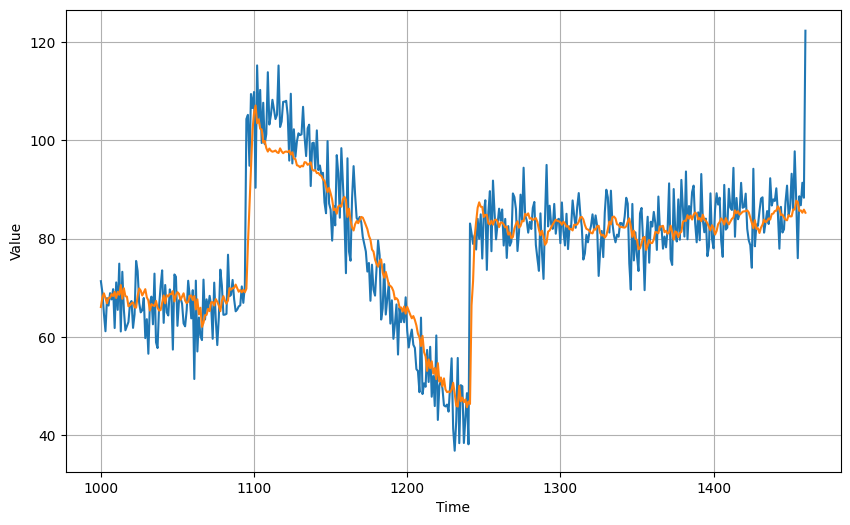

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
# Calculate the mean absolute error by instantiating the metric class
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(x_valid, rnn_forecast)
print(mae_metric.result().numpy())

4.9886513


fully convolutional layer

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 42.7132 - mae: 43.2120 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 42.2183 - mae: 42.7171 - learning_rate: 1.0798e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 41.3930 - mae: 41.8918 - learning_rate: 1.1659e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 42.1896 - mae: 42.6886 - learning_rate: 1.2589e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 41.9175 - mae: 42.4164 - learning_rate: 1.3594e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 41.2671 - mae: 41.7660 - learning_rate: 1.4678e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 40.6890 - mae: 41.1878 - learning_rate: 1.5849e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 38.9278 - mae: 39.4264 - learning_rate: 1.7113e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 38.4055 - mae: 38.9042 - learning_rate: 1.8478e-04
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 35.8743 - mae: 36.3731 - learning_rate: 1.9953e-04
Epoch 11/100
8/8 ━━━━━━━━━━━━━

(np.float64(0.0001), np.float64(0.1), np.float64(0.0), np.float64(30.0))

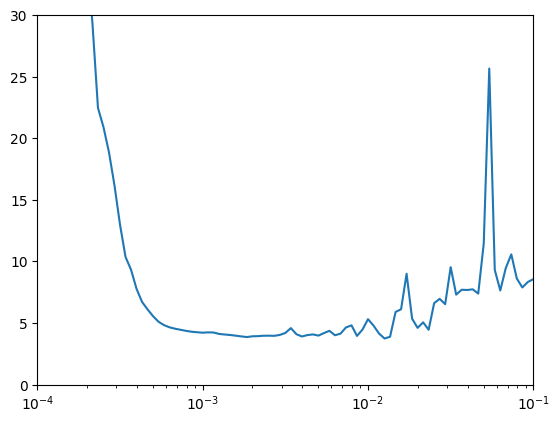

In [21]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


      7/Unknown 5s 75ms/step - loss: 41.4325 - mae: 41.9316

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - loss: 41.3951 - mae: 41.8942 - val_loss: 75.9351 - val_mae: 76.4351
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 40.2115 - mae: 40.7107

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 40.2062 - mae: 40.7054 - val_loss: 73.2100 - val_mae: 73.7100
Epoch 3/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 38.0020 - mae: 38.5008

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 38.0785 - mae: 38.5772 - val_loss: 68.7055 - val_mae: 69.2055
Epoch 4/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 36.6158 - mae: 37.1143

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 36.3403 - mae: 36.8388 - val_loss: 61.0848 - val_mae: 61.5848
Epoch 5/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 31.9610 - mae: 32.4592

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 31.5660 - mae: 32.0641 - val_loss: 47.2184 - val_mae: 47.7184
Epoch 6/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.8485 - mae: 24.3459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 23.3817 - mae: 23.8788 - val_loss: 27.6610 - val_mae: 28.1552
Epoch 7/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 16.7084 - mae: 17.2008

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 16.7233 - mae: 17.2160 - val_loss: 27.2702 - val_mae: 27.7669
Epoch 8/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.4642 - mae: 16.9583

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.3762 - mae: 16.8701 - val_loss: 22.5474 - val_mae: 23.0418
Epoch 9/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 14.0824 - mae: 14.5727

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 14.0365 - mae: 14.5266 - val_loss: 21.6903 - val_mae: 22.1826
Epoch 10/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 13.1073 - mae: 13.5962

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - loss: 13.0047 - mae: 13.4935 - val_loss: 18.0909 - val_mae: 18.5820
Epoch 11/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 11.5920 - mae: 12.0797

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 11.5223 - mae: 12.0101 - val_loss: 15.8978 - val_mae: 16.3877
Epoch 12/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.4889 - mae: 10.9756

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 10.3972 - mae: 10.8838 - val_loss: 13.6079 - val_mae: 14.0957
Epoch 13/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.0568 - mae: 9.5416

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.0159 - mae: 9.5007 - val_loss: 11.5082 - val_mae: 11.9922
Epoch 14/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.1183 - mae: 8.6011

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8.0634 - mae: 8.5462 - val_loss: 9.8865 - val_mae: 10.3702
Epoch 15/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.1994 - mae: 7.6821

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 7.1837 - mae: 7.6662 - val_loss: 8.8077 - val_mae: 9.2905
Epoch 16/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.5697 - mae: 7.0508

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 6.5715 - mae: 7.0526 - val_loss: 8.0269 - val_mae: 8.5086
Epoch 17/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.2268 - mae: 6.7080

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.2028 - mae: 6.6839 - val_loss: 7.2023 - val_mae: 7.6829
Epoch 18/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.7854 - mae: 6.2662

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.7649 - mae: 6.2457 - val_loss: 6.5463 - val_mae: 7.0266
Epoch 19/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 5.3509 - mae: 5.8313

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 5.3463 - mae: 5.8266 - val_loss: 5.9758 - val_mae: 6.4544
Epoch 20/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.1056 - mae: 5.5848

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 5.0934 - mae: 5.5726 - val_loss: 5.5140 - val_mae: 5.9922
Epoch 21/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.9054 - mae: 5.3842

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 4.8938 - mae: 5.3725 - val_loss: 5.2660 - val_mae: 5.7439
Epoch 22/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.7618 - mae: 5.2406

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 4.7536 - mae: 5.2323 - val_loss: 5.1237 - val_mae: 5.6018
Epoch 23/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.6950 - mae: 5.1737

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 4.6823 - mae: 5.1609 - val_loss: 4.9899 - val_mae: 5.4676
Epoch 24/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.5948 - mae: 5.0733

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.5881 - mae: 5.0666 - val_loss: 4.9202 - val_mae: 5.3978
Epoch 25/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.5093 - mae: 4.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 4.5072 - mae: 4.9857 - val_loss: 4.8373 - val_mae: 5.3149
Epoch 26/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.4534 - mae: 4.9311

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 4.4522 - mae: 4.9299 - val_loss: 4.7731 - val_mae: 5.2507
Epoch 27/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.4048 - mae: 4.8815

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 4.4019 - mae: 4.8787 - val_loss: 4.7031 - val_mae: 5.1802
Epoch 28/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 4.3609 - mae: 4.8369

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 4.3575 - mae: 4.8337 - val_loss: 4.6381 - val_mae: 5.1148
Epoch 29/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.3057 - mae: 4.7816

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 4.3042 - mae: 4.7802 - val_loss: 4.5853 - val_mae: 5.0622
Epoch 30/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.2664 - mae: 4.7425

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 4.2627 - mae: 4.7388 - val_loss: 4.5246 - val_mae: 5.0013
Epoch 31/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.2168 - mae: 4.6930

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.2136 - mae: 4.6897 - val_loss: 4.4537 - val_mae: 4.9295
Epoch 32/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.1442 - mae: 4.6194

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.1455 - mae: 4.6207 - val_loss: 4.4291 - val_mae: 4.9052
Epoch 33/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1140 - mae: 4.5891

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.1148 - mae: 4.5900 - val_loss: 4.3844 - val_mae: 4.8602
Epoch 34/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0965 - mae: 4.5718

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 4.0956 - mae: 4.5709 - val_loss: 4.3633 - val_mae: 4.8392
Epoch 35/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.0578 - mae: 4.5332

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 4.0606 - mae: 4.5361 - val_loss: 4.3367 - val_mae: 4.8122
Epoch 36/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 4.0404 - mae: 4.5155 - val_loss: 4.3617 - val_mae: 4.8379
Epoch 37/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 4.0344 - mae: 4.5091 - val_loss: 4.3427 - val_mae: 4.8186
Epoch 38/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 4.0128 - mae: 4.4869

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 4.0143 - mae: 4.4885 - val_loss: 4.3023 - val_mae: 4.7775
Epoch 39/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.0023 - mae: 4.4771

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.0026 - mae: 4.4774 - val_loss: 4.2863 - val_mae: 4.7614
Epoch 40/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 3.9919 - mae: 4.4660 - val_loss: 4.3375 - val_mae: 4.8140
Epoch 41/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9681 - mae: 4.4421

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.9693 - mae: 4.4432 - val_loss: 4.2657 - val_mae: 4.7408
Epoch 42/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.9649 - mae: 4.4393 - val_loss: 4.3024 - val_mae: 4.7779
Epoch 43/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9500 - mae: 4.4239

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 3.9505 - mae: 4.4244 - val_loss: 4.2637 - val_mae: 4.7389
Epoch 44/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 3.9406 - mae: 4.4141 - val_loss: 4.2689 - val_mae: 4.7442
Epoch 45/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 3.9264 - mae: 4.3998 - val_loss: 4.2882 - val_mae: 4.7638
Epoch 46/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.9251 - mae: 4.3979 - val_loss: 4.2789 - val_mae: 4.7547
Epoch 47/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.9149 - mae: 4.3878

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 3.9152 - mae: 4.3880 - val_loss: 4.2527 - val_mae: 4.7277
Epoch 48/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9065 - mae: 4.3789 - val_loss: 4.2583 - val_mae: 4.7333
Epoch 49/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.9103 - mae: 4.3820 - val_loss: 4.2883 - val_mae: 4.7644
Epoch 50/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.8851 - mae: 4.3571

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.8862 - mae: 4.3582 - val_loss: 4.2428 - val_mae: 4.7180
Epoch 51/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.8908 - mae: 4.3628 - val_loss: 4.2569 - val_mae: 4.7322
Epoch 52/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.8703 - mae: 4.3412 - val_loss: 4.2506 - val_mae: 4.7252
Epoch 53/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.8703 - mae: 4.3417 - val_loss: 4.2493 - val_mae: 4.7244
Epoch 54/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.8634 - mae: 4.3343 - val_loss: 4.2635 - val_mae: 4.7390
Epoch 55/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 3.8513 - mae: 4.3225 - val_loss: 4.2541 - val_mae: 4.7297
Epoch 56/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.8298 - mae: 4.2995

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8308 - mae: 4.3005 - val_loss: 4.2371 - val_mae: 4.7131
Epoch 57/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.8272 - mae: 4.2978 - val_loss: 4.2484 - val_mae: 4.7244
Epoch 58/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8308 - mae: 4.3009 - val_loss: 4.2527 - val_mae: 4.7282
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.8192 - mae: 4.2890 - val_loss: 4.2713 - val_mae: 4.7477
Epoch 60/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8095 - mae: 4.2804 - val_loss: 4.2371 - val_mae: 4.7131
Epoch 61/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.7970 - mae: 4.2675 - val_loss: 4.2669 - val_mae: 4.7431
Epoch 62/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8005 - mae: 4.2705

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.7990 - mae: 4.2691 - val_loss: 4.2311 - val_mae: 4.7072
Epoch 63/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.7804 - mae: 4.2507 - val_loss: 4.2729 - val_mae: 4.7490
Epoch 64/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.7972 - mae: 4.2673

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 3.7933 - mae: 4.2634 - val_loss: 4.2248 - val_mae: 4.7006
Epoch 65/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 3.7612 - mae: 4.2310 - val_loss: 4.2591 - val_mae: 4.7349
Epoch 66/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 3.7624 - mae: 4.2322 - val_loss: 4.2326 - val_mae: 4.7081
Epoch 67/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 3.7539 - mae: 4.2236 - val_loss: 4.2723 - val_mae: 4.7480
Epoch 68/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.7477 - mae: 4.2160

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.7487 - mae: 4.2171 - val_loss: 4.2227 - val_mae: 4.6980
Epoch 69/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.7281 - mae: 4.1976 - val_loss: 4.2408 - val_mae: 4.7160
Epoch 70/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.7337 - mae: 4.2024 - val_loss: 4.2538 - val_mae: 4.7293
Epoch 71/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.7258 - mae: 4.1943

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.7259 - mae: 4.1945 - val_loss: 4.2201 - val_mae: 4.6961
Epoch 72/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.7144 - mae: 4.1824 - val_loss: 4.2315 - val_mae: 4.7066
Epoch 73/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.7211 - mae: 4.1891 - val_loss: 4.2262 - val_mae: 4.7012
Epoch 74/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.6982 - mae: 4.1658 - val_loss: 4.2234 - val_mae: 4.6983
Epoch 75/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 3.6934 - mae: 4.1606 - val_loss: 4.2430 - val_mae: 4.7181
Epoch 76/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.6835 - mae: 4.1507

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 3.6847 - mae: 4.1520 - val_loss: 4.2124 - val_mae: 4.6889
Epoch 77/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 3.6889 - mae: 4.1562 - val_loss: 4.2635 - val_mae: 4.7384
Epoch 78/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6787 - mae: 4.1455

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 3.6779 - mae: 4.1447 - val_loss: 4.2098 - val_mae: 4.6858
Epoch 79/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.6758 - mae: 4.1437 - val_loss: 4.2260 - val_mae: 4.7011
Epoch 80/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.6710 - mae: 4.1377 - val_loss: 4.2376 - val_mae: 4.7121
Epoch 81/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 3.6625 - mae: 4.1295 - val_loss: 4.2361 - val_mae: 4.7110
Epoch 82/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 3.6441 - mae: 4.1099 - val_loss: 4.2143 - val_mae: 4.6911
Epoch 83/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6502 - mae: 4.1168 - val_loss: 4.2519 - val_mae: 4.7260
Epoch 84/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 3.6364 - mae: 4.1021 - val_loss: 4.2362 - val_mae: 4.7105
Epoch 85/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.6396 - mae: 4.1058 - val_loss: 4.2163 - val_mae: 4.6919
Epoch 86/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.6313 - mae: 4

In [23]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


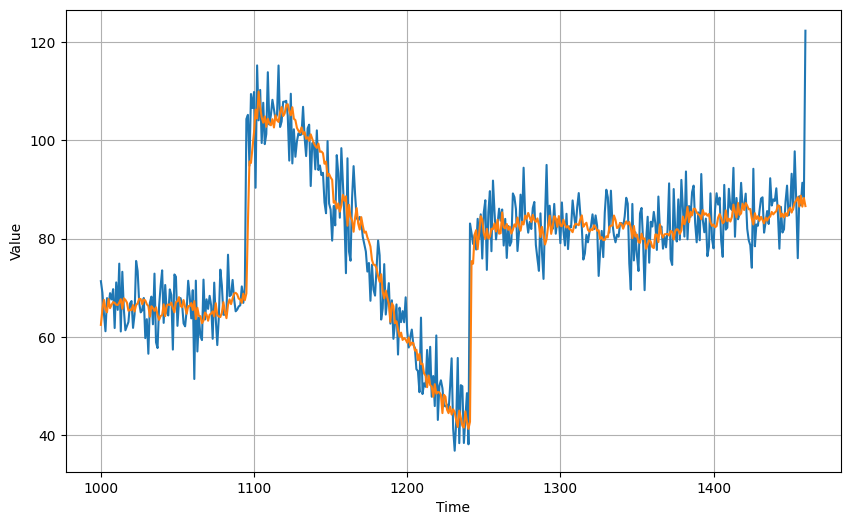

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [28]:
# Calculate the mean absolute error by instantiating the metric class
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(x_valid, cnn_forecast)
print(mae_metric.result().numpy())

4.55751
